# The Best Format to Save Pandas Data

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from collections import defaultdict
import os

In [5]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
from utils import Timer, MemoryTracker, GC, NotebookStyle

In [7]:
style = NotebookStyle()
style.override({'grid.color': 'lightgray'})

## Random Dataset

In [6]:
def generate_dataset(n_rows, num_count, cat_count, max_nan=0.1, max_cat_size=100):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    The categorical features are generated as random uuid4 strings with 
    cardinality C where 2 <= C <= max_cat_size.
    
    Also, a max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    def generate_categories():
        from uuid import uuid4
        category_size = np.random.randint(2, max_cat_size)
        return [str(uuid4()) for _ in range(category_size)]
    
    for col in range(num_count):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
        
    for col in range(cat_count):
        name = f'c{col}'
        cats = generate_categories()
        values = np.array(np.random.choice(cats, n_rows, replace=True), dtype=object)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'object'
    
    return pd.DataFrame(dataset), types

## Benchmarking

In [7]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [8]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [9]:
def benchmark(list_of_formats, data_size=1_000_000, n_num=15, n_cat=15, n_rounds=20,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...')
        dataset, _ = generate_dataset(data_size, n_num, n_cat)
        
        if as_category:
            print('\tconverting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        benchmark = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print('\ttesting format:', fmt)
                filename = f'random.{fmt}'
                save, load = get_save_load(dataset, fmt)
                results = defaultdict(int)
                results['format'] = fmt
                results['filename'] = filename
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        save(filename, **params)
                results['size_mb'] = size_of(filename)
                results['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['save_time'] = float(timer)
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        _ = load(filename)
                results['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['load_time'] = float(timer)
                
                benchmark.append(results)
                
            run = pd.DataFrame(benchmark)
            run['run_no'] = i
            runs.append(run)
            
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark

### CSV Baseline

In [10]:
formats = [('csv', {'index': None})]

In [11]:
csv_results = benchmark(formats, n_rounds=5)

Benchmarking round #1
	generating dataset...
	testing format: csv


KeyboardInterrupt: 

In [ ]:
csv_results.to_feather('baseline.feather')

In [ ]:
baseline = feather.read_dataframe('baseline.feather')

In [ ]:
baseline

,format,filename,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time,run_no
0,csv,random.csv,770.80,4.75,21.380458,498.015625,7.861418,0
1,csv,random.csv,768.67,0.00,22.436221,498.605469,9.130615,1
2,csv,random.csv,767.64,0.00,21.246714,505.640625,7.616253,2
3,csv,random.csv,770.04,0.00,21.363276,473.722656,7.690836,3
4,csv,random.csv,763.94,0.00,21.610478,497.691406,7.567165,4


### Categoricals As Strings

In [ ]:
formats = [
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [ ]:
results = benchmark(formats)

Benchmarking round #1
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #7
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #8
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #9
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #10
	generating dataset...
	testing format: feather
	testing format: parquet
Benchmarking round #11
	generating dataset...
	te

In [ ]:
results.to_feather('one_million_cats_str.feather')

In [ ]:
results = feather.read_dataframe('one_million_cats_str.feather')

In [ ]:
results = pd.concat([baseline, results], axis=0, sort=False)

In [ ]:
print(results.isnull().sum())


format               0
filename             0
size_mb              0
save_ram_delta_mb    0
save_time            0
load_ram_delta_mb    0
load_time            0
run_no               0
dtype: int64


In [ ]:
avg = results.groupby('format').mean(numeric_only=True).reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,768.2180,0.950000,21.607429,494.735156,7.973257
1,feather,225.6625,794.471875,1.223743,503.852539,0.561361
2,parquet,125.5905,157.387695,2.264781,1367.403125,0.814259


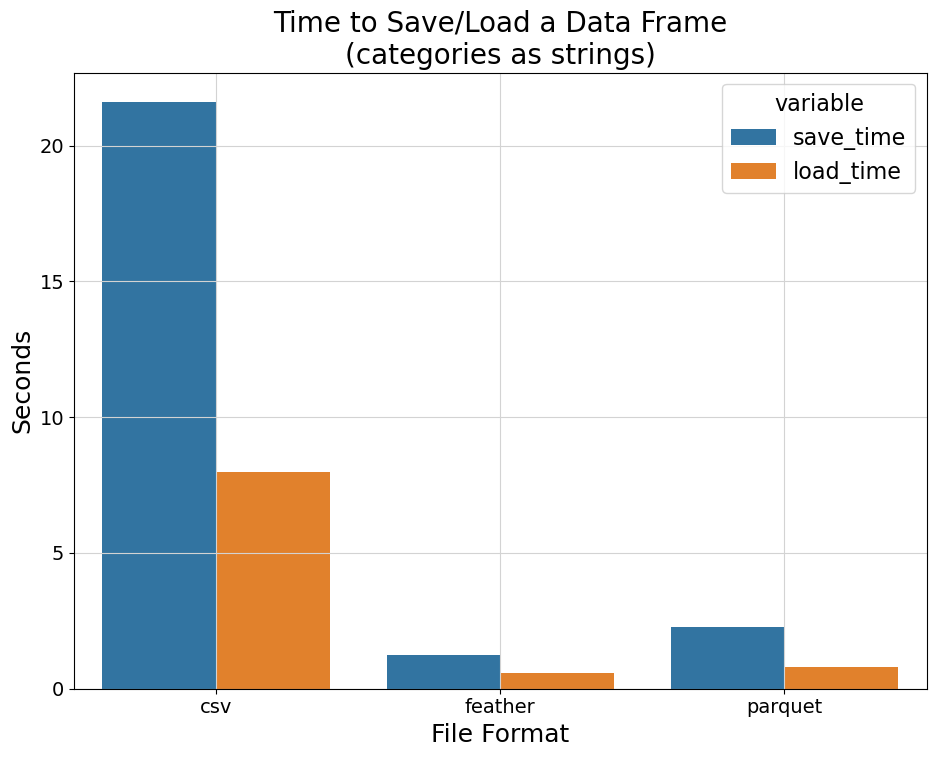

In [ ]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)

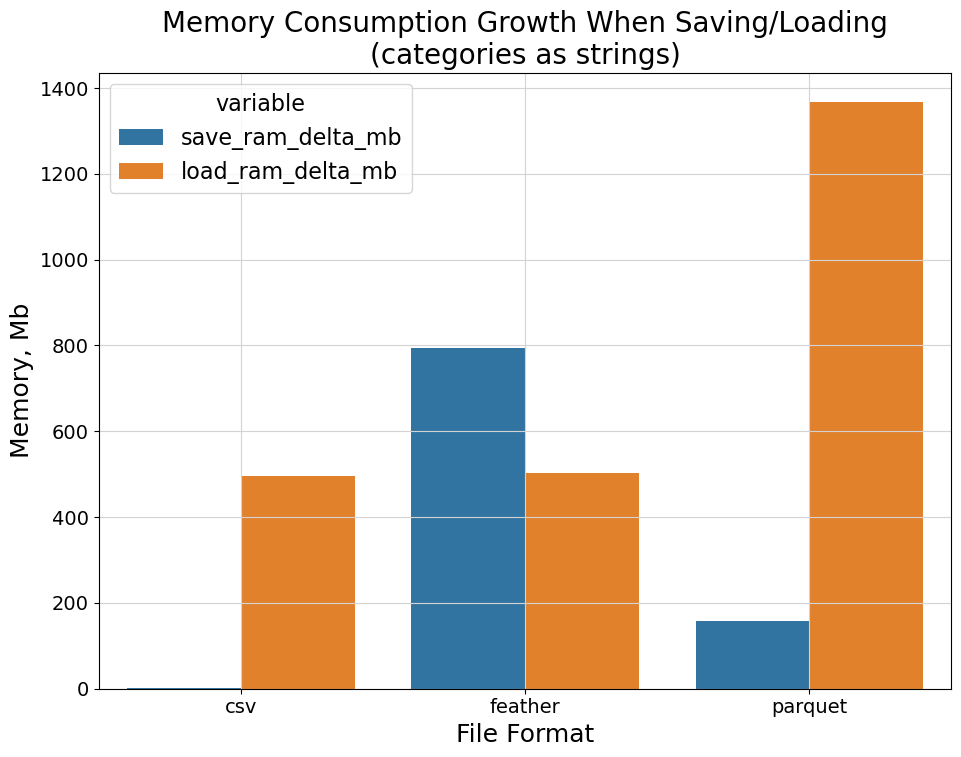

In [ ]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as strings)')
ax.grid(True)

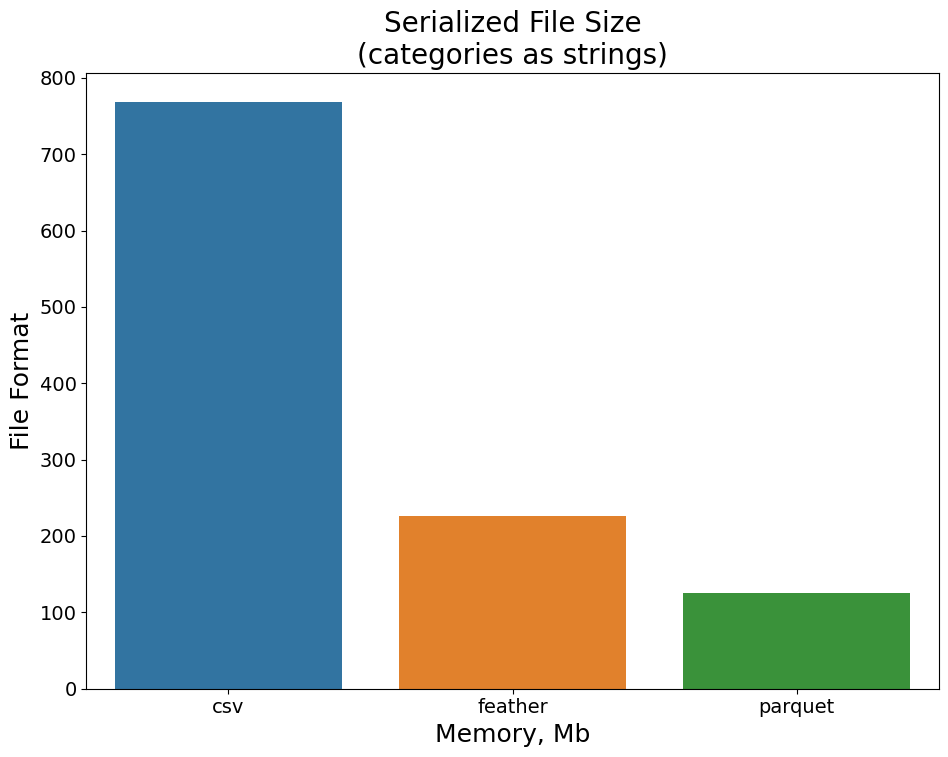

In [ ]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as strings)')

### Categoricals As Dedicated Category Type

In [ ]:
results = benchmark(formats, as_category=True)

Benchmarking round #1
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: feather
	testing format: parquet
Benchmarking round #7
	generating dataset...
	converting categorical columns into pandas.Category
	testing forma

In [ ]:
results.to_feather('one_million_cats_category.feather')

In [ ]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [ ]:
results = pd.concat([baseline, results], axis=0)

In [ ]:
avg = results.groupby('format').mean(numeric_only=True).reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,768.2180,0.950000,21.607429,494.735156,7.973257
1,feather,126.1735,18.787500,0.100938,221.273828,0.118989
2,parquet,124.3690,35.200781,0.698727,328.076367,0.244887


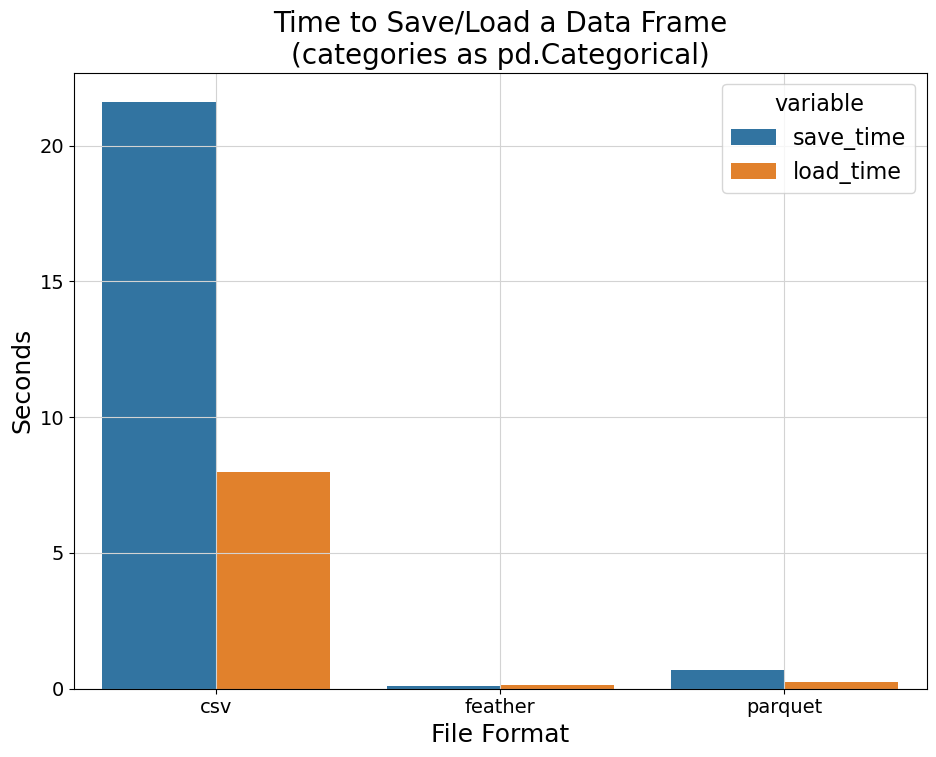

In [ ]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

In [8]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [9]:
avg = results.groupby('format').mean(numeric_only=True).reset_index().drop(columns=['run_no'])

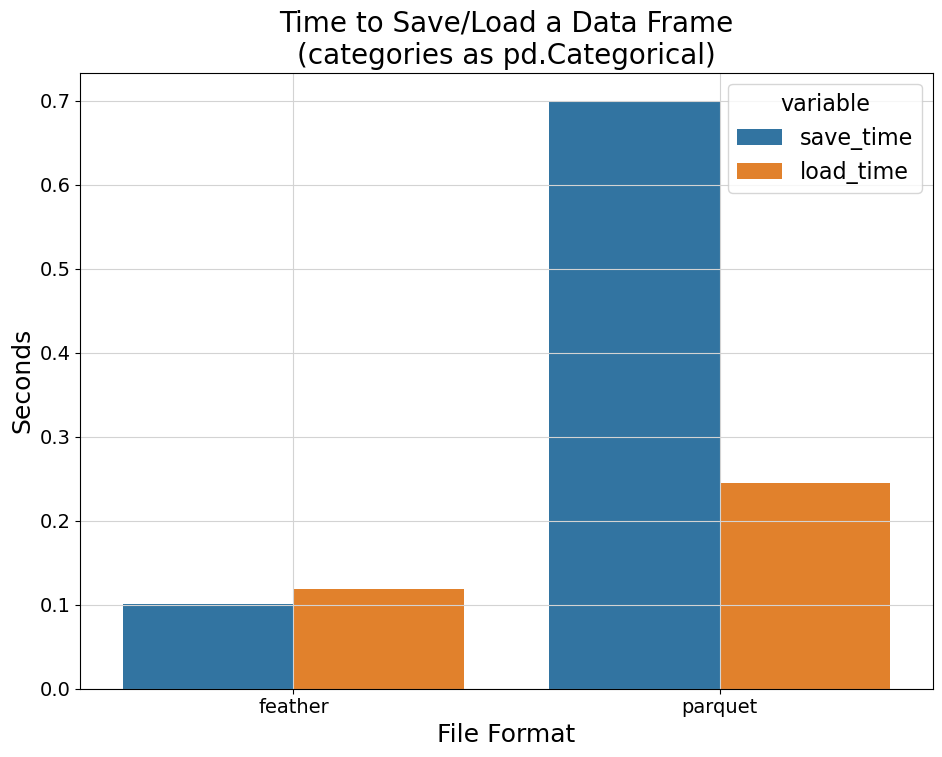

In [10]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

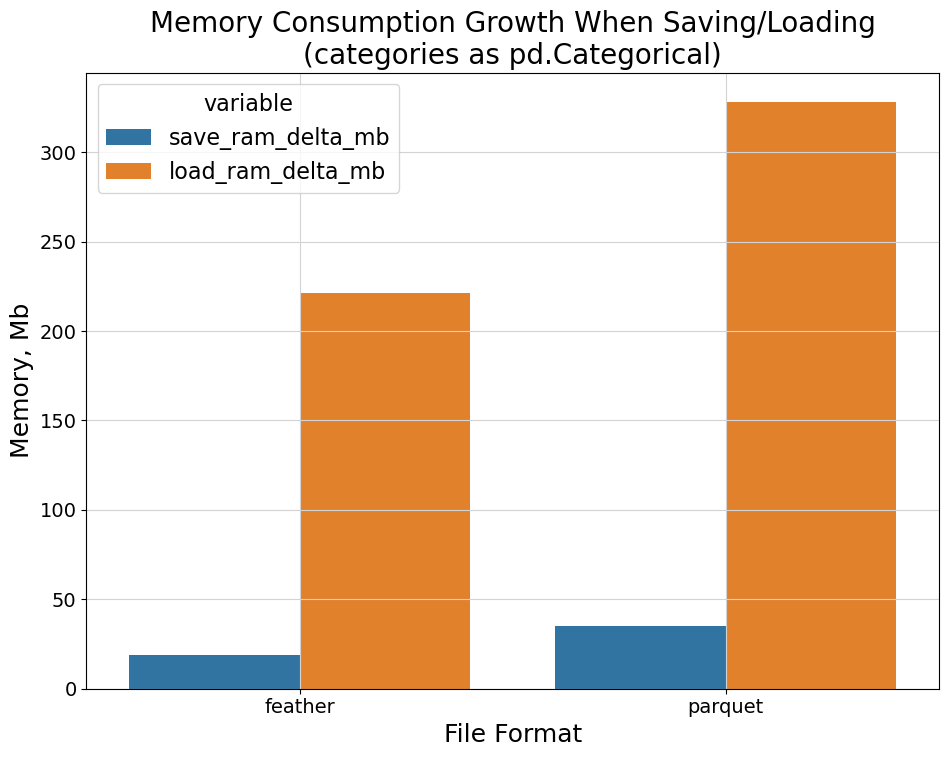

In [11]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as pd.Categorical)')
ax.grid(True)

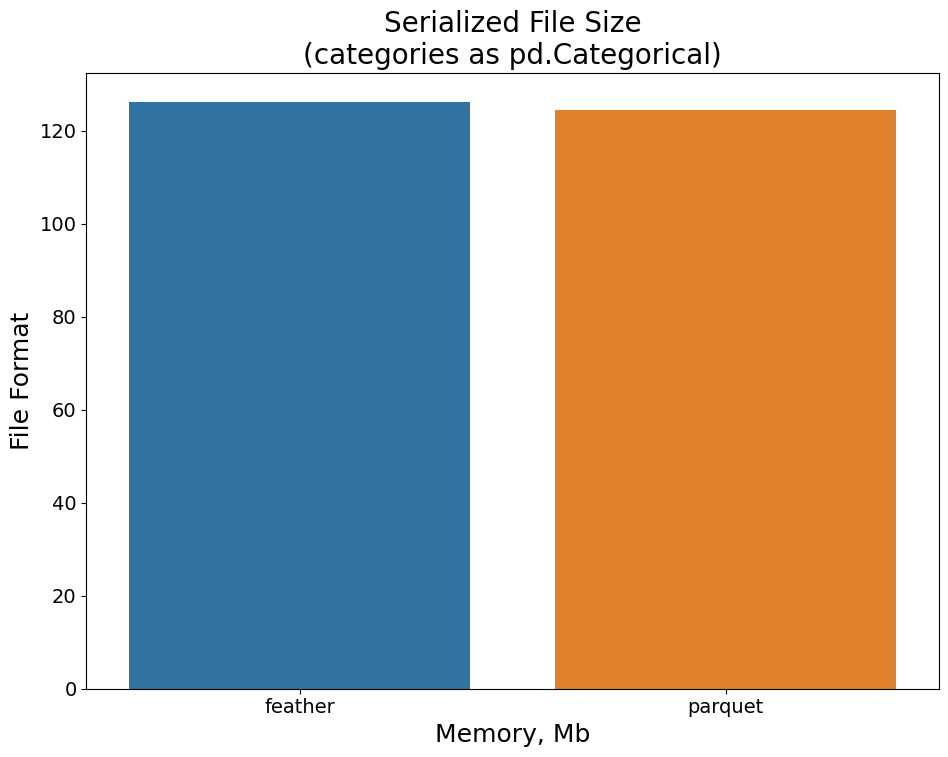

In [12]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as pd.Categorical)')

## Savings from switching

In [13]:
import pandas as pd

def calculate_time_saved(data, from_format, to_format, time_type='total'):
    format_idx = {'csv': 0, 'feather': 1, 'parquet': 2}

    from_format_idx = format_idx[from_format]
    to_format_idx = format_idx[to_format]

    if time_type == 'saving':
        time_from = data.loc[from_format_idx, 'save_time']
        time_to = data.loc[to_format_idx, 'save_time']
    elif time_type == 'loading':
        time_from = data.loc[from_format_idx, 'load_time']
        time_to = data.loc[to_format_idx, 'load_time']
    else:
        save_time_from = data.loc[from_format_idx, 'save_time']
        load_time_from = data.loc[from_format_idx, 'load_time']
        save_time_to = data.loc[to_format_idx, 'save_time']
        load_time_to = data.loc[to_format_idx, 'load_time']
        time_from = save_time_from + load_time_from
        time_to = save_time_to + load_time_to

    total_time_saved = time_from - time_to

    return total_time_saved

from_format = 'csv'
to_format = 'parquet'
time_type = 'loading'  # You can change this to 'saving' or 'loading' or 'total'

time_saved = calculate_time_saved(avg, from_format, to_format, time_type)
print(f"Time saved from switching from {from_format} to {to_format} ({time_type} time): {time_saved} seconds")


KeyError: 2

In [ ]:
def calculate_yearly_time_savings(data, from_format, to_format, read_per_week, write_per_week, persons=1, time_unit='seconds'):
    days_per_week = 7
    weeks_per_year = 52

    read_time_saved = calculate_time_saved(data, from_format, to_format, time_type='loading') * read_per_week
    write_time_saved = calculate_time_saved(data, from_format, to_format, time_type='saving') * write_per_week

    total_time_saved_per_week = read_time_saved + write_time_saved
    total_time_saved_per_year = total_time_saved_per_week * weeks_per_year * persons

    if time_unit == 'minutes':
        total_time_saved_per_year /= 60
    elif time_unit == 'hours':
        total_time_saved_per_year /= 3600

    return total_time_saved_per_year


from_format = 'csv'
to_format = 'parquet'
read_per_week = 5  # Number of reads per week
write_per_week = 2  # Number of writes per week
persons = 15  # Number of persons performing the tasks
time_unit = 'hours'  # Change to 'minutes' if you want the time savings in minutes

yearly_time_savings = calculate_yearly_time_savings(avg, from_format, to_format, read_per_week, write_per_week, persons, time_unit)
print(f"Yearly time savings from switching from {from_format} to {to_format}: {yearly_time_savings:.2f} {time_unit}")


Yearly time savings from switching from csv to parquet: 17.43 hours


In [14]:
import locale


In [15]:
def calculate_yearly_monetary_savings(data, from_format, to_format, read_per_week, write_per_week, persons=1, daily_wage=0, time_unit='seconds'):
    days_per_week = 7
    weeks_per_year = 52

    read_time_saved = calculate_time_saved(data, from_format, to_format, time_type='loading') * read_per_week
    write_time_saved = calculate_time_saved(data, from_format, to_format, time_type='saving') * write_per_week

    total_time_saved_per_week = read_time_saved + write_time_saved
    total_time_saved_per_year = total_time_saved_per_week * weeks_per_year * persons

    if time_unit == 'minutes':
        total_time_saved_per_year /= 60
    elif time_unit == 'hours':
        total_time_saved_per_year /= 3600

    monetary_savings_per_year = total_time_saved_per_year * daily_wage

    return monetary_savings_per_year

# Create a pandas DataFrame with your data
# Set the locale to Mexican peso (MXN) format
locale.setlocale(locale.LC_ALL, 'es_MX.UTF-8')
from_format = 'csv'
to_format = 'parquet'
read_per_week = 5  # Number of reads per week
write_per_week = 2  # Number of writes per week
persons = 15  # Number of persons performing the tasks
daily_wage = 2000  # Daily wage in your currency
time_unit = 'hours'  # Change to 'minutes' if you want the time savings in minutes

yearly_monetary_savings = calculate_yearly_monetary_savings(avg, from_format, to_format, read_per_week, write_per_week, persons, daily_wage, time_unit)
# Format monetary savings as Mexican pesos (MXN)
formatted_savings = locale.currency(yearly_monetary_savings, grouping=True)

print(f"Yearly monetary savings from switching from {from_format} to {to_format}: {formatted_savings}")


KeyError: 2

In [16]:
import matplotlib.pyplot as plt
# Set the locale to Mexican peso (MXN) format
locale.setlocale(locale.LC_ALL, 'es_MX.UTF-8')
from_format = 'csv'
to_format = 'parquet'
read_per_week = 5  # Number of reads per week
write_per_week = 2  # Number of writes per week
persons = 15  # Number of persons performing the tasks
daily_wage = 2000  # Daily wage in your currency
time_unit = 'hours'  # Change to 'minutes' if you want the time savings in minutes
# Generate data for the plots
reads_range = range(1, 11)  # Number of reads per week from 1 to 10
writes_range = range(1, 11)  # Number of writes per week from 1 to 10

read_savings = []
write_savings = []

for reads in reads_range:
    read_savings.append(calculate_yearly_monetary_savings(avg, from_format, to_format, reads, write_per_week, persons, daily_wage, time_unit))

for writes in writes_range:
    write_savings.append(calculate_yearly_monetary_savings(avg, from_format, to_format, read_per_week, writes, persons, daily_wage, time_unit))


# Create the first plot (Number of Reads vs. Monetary Savings)
plt.figure(figsize=(10, 5))
plt.bar(reads_range, read_savings)
plt.xlabel('Number of Reads per Week')
plt.ylabel('')
plt.title('Yearly Monetary Savings (MXN)')
plt.ticklabel_format(style='plain', axis='y', useLocale=True)  # Add thousands separator to y-axis
plt.xticks(writes_range)  # Show all tick marks on the x-axis
plt.show()

# Create the second plot (Number of Writes vs. Monetary Savings)
plt.figure(figsize=(10, 5))
plt.bar(writes_range, write_savings)
plt.xlabel('Number of Writes per Week')
plt.ylabel('')
plt.title('Yearly Monetary Savings (MXN)')
plt.ticklabel_format(style='plain', axis='y', useLocale=True)  # Add thousands separator to y-axis
plt.xticks(writes_range)  # Show all tick marks on the x-axis
plt.show()


KeyError: 2

In [17]:
import plotly.express as px
import locale

# Set the locale to Mexican peso (MXN) format
locale.setlocale(locale.LC_ALL, 'es_MX.UTF-8')
# Generate data for the plots
reads_range = range(1, 11)  # Number of reads per week from 1 to 10
writes_range = range(1, 11)  # Number of writes per week from 1 to 10

# Create a pandas DataFrame with your data
data = pd.DataFrame({
    'format': ['csv', 'feather', 'parquet'],
    'size_mb': [768.2180, 225.6625, 125.5905],
    'save_ram_delta_mb': [0.950000, 794.471875, 157.387695],
    'save_time': [21.607429, 1.223743, 2.264781],
    'load_ram_delta_mb': [494.735156, 503.852539, 1367.403125],
    'load_time': [7.973257, 0.561361, 0.814259]
})

from_format = 'csv'
to_format = 'parquet'
persons = 15
daily_wage = 2000
time_unit = 'hours'

# Generate data for the combined savings plot
combined_savings = []

for reads in reads_range:
    for writes in writes_range:
        combined_savings.append(calculate_yearly_monetary_savings(data, from_format, to_format, reads, writes, persons, daily_wage, time_unit))
# Create a bar plot using Plotly
fig = px.bar(x=[f'Reads: {r}, Writes: {w}' for r in reads_range for w in writes_range], y=combined_savings,
             labels={'x': 'Combined Read and Write Scenarios', 'y': 'Yearly Monetary Savings (MXN)'},
             title='Combined Yearly Monetary Savings (MXN) from Reading and Writing')

# Remove x-axis ticks
fig.update_xaxes(tickvals=[])

# Format y-axis labels with thousands separator
fig.update_layout(yaxis_tickformat=',.0f', yaxis_title='Yearly Monetary Savings (MXN)')

fig.show()

In [23]:
import plotly.graph_objects as go
import locale

# Set the locale to Mexican peso (MXN) format
locale.setlocale(locale.LC_ALL, 'es_MX.UTF-8')

# Generate data for the plots
reads_range = range(1, 11)  # Number of reads per week from 1 to 10
writes_range = range(1, 11)  # Number of writes per week from 1 to 10

# Create a pandas DataFrame with your data
data = pd.DataFrame({
    'format': ['csv', 'feather', 'parquet'],
    'size_mb': [768.2180, 225.6625, 125.5905],
    'save_ram_delta_mb': [0.950000, 794.471875, 157.387695],
    'save_time': [21.607429, 1.223743, 2.264781],
    'load_ram_delta_mb': [494.735156, 503.852539, 1367.403125],
    'load_time': [7.973257, 0.561361, 0.814259]
})

from_format = 'csv'
to_format = 'parquet'
persons = 15
daily_wage = 2000
time_unit = 'hours'

# Generate data for the combined savings
combined_savings = []

for reads in reads_range:
    for writes in writes_range:
        combined_savings.append(calculate_yearly_monetary_savings(data, from_format, to_format, reads, writes, persons, daily_wage, time_unit))
# Reshape combined_savings to match the shape of z in the example
combined_savings_reshaped = np.array(combined_savings).reshape(len(reads_range), len(writes_range))
# Create a 3D surface plot using Plotly's graph_objects
fig = go.Figure(data=[go.Surface(z=combined_savings_reshaped, x=list(writes_range), y=list(reads_range))])

# Customize the tooltip text
tooltip_text = [[f'Reads: {reads}<br>Writes: {writes}<br>Savings: MXN {savings:,.2f}' for writes, savings in zip(writes_range, row)] for reads, row in zip(reads_range, combined_savings_reshaped)]
tooltip_text = np.array(tooltip_text)

fig.update_traces(hoverinfo='text', text=tooltip_text)

fig.update_layout(title='Combined Yearly Monetary Savings (MXN) from Reading and Writing',
                  scene=dict(xaxis_title='Number of Writes', yaxis_title='Number of Reads', zaxis_title='Yearly Monetary Savings (MXN)'),
                  autosize=False, width=800, height=600)
fig.show()

# Dash app

In [25]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np


# Generate data for the plots
reads_range = range(1, 11)  # Number of reads per week from 1 to 10
writes_range = range(1, 11)  # Number of writes per week from 1 to 10

# Create a pandas DataFrame with your data
data = pd.DataFrame({
    'format': ['csv', 'feather', 'parquet'],
    'size_mb': [768.2180, 225.6625, 125.5905],
    'save_ram_delta_mb': [0.950000, 794.471875, 157.387695],
    'save_time': [21.607429, 1.223743, 2.264781],
    'load_ram_delta_mb': [494.735156, 503.852539, 1367.403125],
    'load_time': [7.973257, 0.561361, 0.814259]
})

# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Interactive Savings Calculator"),
    html.Label("Number of Reads per Week"),
    dcc.Slider(id='reads-slider', min=1, max=10, step=1, value=5),
    html.Label("Number of Writes per Week"),
    dcc.Slider(id='writes-slider', min=1, max=10, step=1, value=5),
    html.Label("Number of People"),
    dcc.Slider(id='persons-slider', min=1, max=20, step=1, value=10),
    html.Label("Daily Wage (MXN)"),
    dcc.Input(id='wage-input', type='number', value=2000),
    dcc.Graph(id='savings-graph')
])

# Callback to update the savings graph
@app.callback(
    Output('savings-graph', 'figure'),
    [Input('reads-slider', 'value'),
     Input('writes-slider', 'value'),
     Input('persons-slider', 'value'),
     Input('wage-input', 'value')]
)
def update_graph(reads, writes, persons, wage):
    # Generate data for the combined savings plot
    combined_savings = []

    for r in reads_range:
        for w in writes_range:
            combined_savings.append(calculate_yearly_monetary_savings(data, 'csv', 'parquet', r, w, persons, wage, 'hours'))

    combined_savings_reshaped = np.array(combined_savings).reshape(len(reads_range), len(writes_range))

    # Create a 3D surface plot
    fig = go.Figure(data=[go.Surface(z=combined_savings_reshaped, x=list(writes_range), y=list(reads_range))])

    fig.update_traces(hoverinfo='text', text=[[f'Reads: {r}<br>Writes: {w}<br>Savings: MXN {s:,.2f}' for w, s in zip(writes_range, row)] for r, row in zip(reads_range, combined_savings_reshaped)])
    
    fig.update_layout(title='Combined Yearly Monetary Savings (MXN) from Reading and Writing',
                      scene=dict(xaxis_title='Number of Writes', yaxis_title='Number of Reads', zaxis_title='Yearly Monetary Savings (MXN)'),
                      autosize=False, width=800, height=600)
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


ImportError: cannot import name 'get_current_traceback' from 'werkzeug.debug.tbtools' (/home/duque/miniconda3/lib/python3.10/site-packages/werkzeug/debug/tbtools.py)